In [67]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.transforms import ToTensor

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.kl import kl_divergence
import torchvision
import numpy as np

import torch
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt 
writer = SummaryWriter('mnist_experiment_1')

<IPython.core.display.Javascript object>

In [69]:
bs = 16
# MNIST Dataset
train_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)


<IPython.core.display.Javascript object>

In [70]:
class VAE(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: list, z_dim):
        super(VAE, self).__init__()
        
        self.z_dim = z_dim
        
        self.encoder_layers = nn.ModuleList([nn.Linear(input_dim, hidden_dim[0])])
        self.decoder_layers = nn.ModuleList([nn.Linear(hidden_dim[0], input_dim)])
                
        if len(hidden_dim)>1:
            for i in range(len(hidden_dim)-1):
                self.encoder_layers.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))
                self.decoder_layers.insert(0, nn.Linear(hidden_dim[i+1], hidden_dim[i]))
                
        self.encoder_layers.append(nn.Linear(hidden_dim[-1], 2 * z_dim))
        self.decoder_layers.insert(0, nn.Linear(z_dim, hidden_dim[-1]))

        
    def encoder(self, x):
        for idx, layer in enumerate(self.encoder_layers):
            x = layer(x)
            if idx < len(self.encoder_layers) - 1:
                # x = F.dropout(x, 0.01)
                x = F.relu(x)
        return x[...,:self.z_dim], x[...,self.z_dim:] # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        # std = torch.abs(log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        for idx, layer in enumerate(self.decoder_layers):
            z = layer(z)
            if idx < len(self.decoder_layers) - 1:
                # x = F.dropout(x, 0.01)
                z = F.relu(z)
        return torch.sigmoid(z) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        
    #    z = self.sampling(mu, log_var)
        latent = MultivariateNormal(loc = mu, 
                                    scale_tril=torch.diag_embed(torch.exp(0.5*log_var)))
        z = latent.rsample()
           
    #    return self.decoder(z), mu, log_var
        return self.decoder(z), latent

    @staticmethod
    def loss_function(recon_x, x, mu, log_var):
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return BCE + KLD
    
    @staticmethod
    def loss_function_dist(recon_x, x, latent):
        prior = MultivariateNormal(loc = torch.zeros(latent.mean.shape[1]),
                                   scale_tril=torch.eye(latent.mean.shape[1]))
        
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
        KLD = torch.sum(kl_divergence(latent, prior))
        return BCE + KLD

<IPython.core.display.Javascript object>

In [71]:
# build model

#%%
vae = VAE(input_dim=784, hidden_dim=[512, 256], z_dim=16)
# if torch.backends.mps.is_available():
#     DEVICE = 'mps'
# else:
DEVICE = 'cpu'
    
vae.to(DEVICE)

optimizer = optim.Adam(vae.parameters())

def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        
        
        data = data.to(DEVICE)
        optimizer.zero_grad()
        
        recon_batch, latent = vae(data)
        loss = VAE.loss_function_dist(recon_batch, data, latent)
        writer.add_scalar("Loss/train", loss, epoch)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    

<IPython.core.display.Javascript object>

In [72]:
#%%
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(DEVICE)
            #recon, mu, log_var = vae(data)
            recon, latent = vae(data)
            
            test_loss += VAE.loss_function_dist(recon, data, latent).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

<IPython.core.display.Javascript object>

Train Epoch: 1 [0/60000 (0%)]	Loss: 543.244812
Train Epoch: 1 [1600/60000 (3%)]	Loss: 222.569534
Train Epoch: 1 [3200/60000 (5%)]	Loss: 204.033539
Train Epoch: 1 [4800/60000 (8%)]	Loss: 165.067505
Train Epoch: 1 [6400/60000 (11%)]	Loss: 168.547974
Train Epoch: 1 [8000/60000 (13%)]	Loss: 143.615097
Train Epoch: 1 [9600/60000 (16%)]	Loss: 132.929901
Train Epoch: 1 [11200/60000 (19%)]	Loss: 156.778931
Train Epoch: 1 [12800/60000 (21%)]	Loss: 126.202980
Train Epoch: 1 [14400/60000 (24%)]	Loss: 136.198090
Train Epoch: 1 [16000/60000 (27%)]	Loss: 137.735611
Train Epoch: 1 [17600/60000 (29%)]	Loss: 144.933182
Train Epoch: 1 [19200/60000 (32%)]	Loss: 114.093796
Train Epoch: 1 [20800/60000 (35%)]	Loss: 139.265091
Train Epoch: 1 [22400/60000 (37%)]	Loss: 137.249222
Train Epoch: 1 [24000/60000 (40%)]	Loss: 138.788467
Train Epoch: 1 [25600/60000 (43%)]	Loss: 129.764053
Train Epoch: 1 [27200/60000 (45%)]	Loss: 126.012100
Train Epoch: 1 [28800/60000 (48%)]	Loss: 138.891541
Train Epoch: 1 [30400/6000

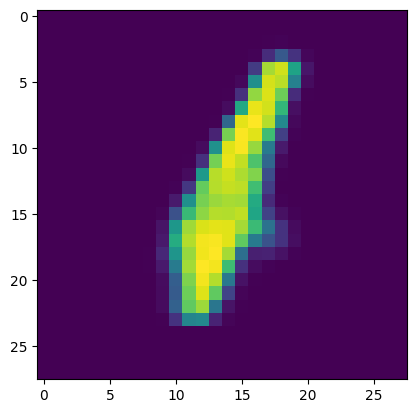

<IPython.core.display.Javascript object>

In [73]:
#%%
for epoch in range(1, 5):
    train(epoch)
    test()
# %%
import matplotlib.pyplot as plt
z = torch.randn(64, 16)
sample = vae.decoder(z).detach()
plt.imshow(sample.view(64, 1, 28, 28)[2].permute(1, 2, 0)  )
#%%
for batch_idx, (data, _) in enumerate(train_loader):
    data = data.to(DEVICE)
    optimizer.zero_grad()
    
    recon_batch, latent = vae(data)
    
    break
#%%

prior = MultivariateNormal(loc = torch.zeros(latent.mean.shape[1]),
                           scale_tril=torch.eye(latent.mean.shape[1]))

BCE = F.binary_cross_entropy(recon_batch, data.view(-1, 784), reduction='none')
KLD = kl_divergence(latent, prior)

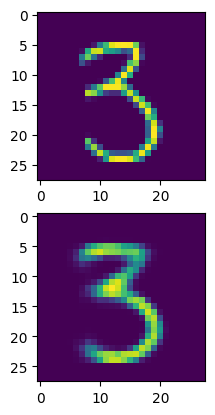

<IPython.core.display.Javascript object>

In [74]:
# %%
idx = 4
ax = plt.subplot(2,1,1)
plt.imshow(data[idx,:].permute(1, 2, 0)  )
ax = plt.subplot(2,1,2)
plt.imshow(recon_batch.detach().view(16, 1, 28, 28)[idx].permute(1, 2, 0))

# %%

Permute some pixals of an image

In [75]:

# Get the dimensions of the image tensor
C, H, W = data[1].shape

# Define the number of pixels to permute and randomly select pixel indices
num_pixels_to_permute = int(H*W*0.4) # permute only 50% of pixels
perm_indices = torch.randperm(H*W)[:num_pixels_to_permute]

# Define the subset of pixels to be permuted
subset_indices = torch.randperm(num_pixels_to_permute)[:num_pixels_to_permute//2]

# Create a tensor to hold the permutation order for the selected pixels
perm_order = torch.randperm(num_pixels_to_permute//2)

# Flatten the image tensor and permute the selected pixels
flat_img_tensor = data[1].detach().clone().view(C, H*W)
flat_img_tensor[:, perm_indices[subset_indices]] = flat_img_tensor[:, perm_indices[subset_indices[perm_order]]]

# Reshape the permuted tensor back to its original shape
permuted_img_tensor = flat_img_tensor.view(C, H, W)



<IPython.core.display.Javascript object>

In [76]:
recon_test_orig, latent_test_orig = vae(data[1])

<IPython.core.display.Javascript object>

In [77]:
recon_test, latent_test = vae(permuted_img_tensor)

<IPython.core.display.Javascript object>

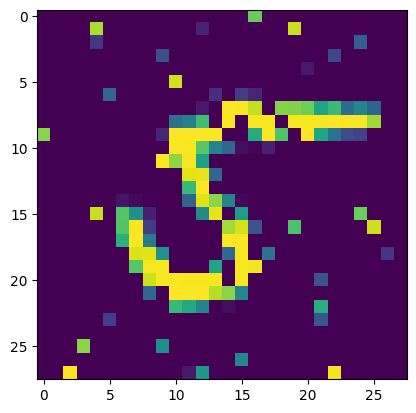

<IPython.core.display.Javascript object>

In [78]:
plt.imshow(permuted_img_tensor.detach().view(1, 28, 28).permute(1, 2, 0))

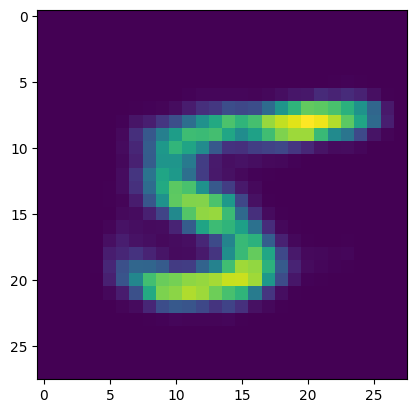

<IPython.core.display.Javascript object>

In [79]:
plt.imshow(recon_test.detach().view(1, 28, 28).permute(1, 2, 0))

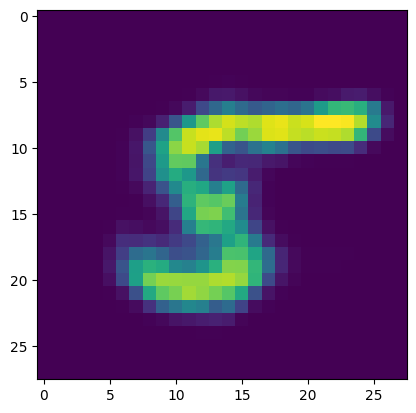

<IPython.core.display.Javascript object>

In [80]:
plt.imshow(recon_test_orig.detach().view(1, 28, 28).permute(1, 2, 0))